# Venice levels with TinyTimeMixer (TTM)

This notebook demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-1024-96 model. That means the TTM model can take an input of 1024 time points (`context_length`), and can forecast up to 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try the TTM-512-96 model or any new model available at the [Hugging Face TTM Model Repository](https://huggingface.co/ibm/TTM).

Pre-trained TTM models will be fetched from the [Hugging Face TTM Model Repository](https://huggingface.co/ibm/TTM).

## Defines and Imports

In [1]:
# Clone the ibm/tsfm
! git clone https://github.com/ibm-granite/granite-tsfm.git
!ls

# Change directory. Move inside the tsfm repo.
%cd granite-tsfm
! ls

# Install the tsfm library
! pip install ".[notebooks]"

fatal: destination path 'granite-tsfm' already exists and is not an empty directory.
granite-tsfm
/home/wsuser/work/granite-tsfm


/opt/conda/envs/Python-RT24.1-CUDA/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


build	  notebooks	  scripts   tsfmhfdemos		  ttm_finetuned_models
LICENSE   pyproject.toml  services  tsfm_public		  wiki.md
Makefile  README.md	  tests     tsfm_public.egg-info
Processing /home/wsuser/work/granite-tsfm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tsfm_public: filename=tsfm_public-0.2.10.dev14+gc889210-py3-none-any.whl size=2322468 sha256=bdfcbed655ddbbdf0a26aa655abff1f335b5a95f6ac32c9d39aa9ec64ddaa114
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/4b/d1/e2/0fffd74c748d955a3e6537760bafc36eedfaac160a7d165938
Successfully built tsfm_public
  Attempting uninstall: tsfm_public
    Found existing installation: tsfm_public 0.2.10.dev14+gc889210
    Uninstalling tsfm_public-0.2.10.dev14+gc889210:
      Successfully uninstalled tsfm_public-0.2.10.dev14+gc889210


In [2]:
# Insert the credentials to access the dataset here
credentials = {
    'IBM_API_KEY_ID': '*******************************',
    'IAM_SERVICE_ID': '*******************************',
    'ENDPOINT': '*******************************',
    'IBM_AUTH_ENDPOINT': '*******************************',
    'BUCKET': '*******************************',
    'FILE': '*******************************'
}

### Imports

In [3]:
# Standard
import os, types
import math
import tempfile
import torch

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd
from botocore.client import Config
import ibm_boto3

# tsfm library
from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets
)
from tsfm_public.toolkit.visualization import plot_predictions

2024-09-16 07:17:36.143333: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 07:17:36.143359: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 07:17:36.143364: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Important arguments

In [4]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Data loading, cleaning, manipulation, visualization, and saving tasks are performed in another notebook and saved in a github repository.
target_dataset = "venice"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
TTM_MODEL_REVISION = "1024_96_v1"
TTM_INPUT_SEQ_LEN = 1024


## Helper functions

### Load and pre-process data

In [5]:
# Function to get_data
# Define data loaders using TSP from the tsfm library
def get_data(
    dataset_name: str,
    context_length,
    forecast_length,
    fewshot_fraction=1.0,
):
    print(dataset_name, context_length, forecast_length)
    
    #  ---------- Access the dataset in the COS ----------
    def __iter__(self): return 0
    
    cos_client = ibm_boto3.client(service_name='s3',
        ibm_api_key_id=credentials['IBM_API_KEY_ID'],
        ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
        ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
        config=Config(signature_version='oauth'),
        endpoint_url=credentials['ENDPOINT'])

    bucket = credentials['BUCKET']
    object_key = credentials['FILE']

    body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
    # add missing __iter__ method, so pandas accepts body as file-like object
    if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
        
    data = pd.read_csv(body, parse_dates=["DATE"])
    data.head(10)
        
    # ----------------------------------------------------

    column_specifiers = {
        "timestamp_column": "DATE",
        "id_columns": [],
        "target_columns": ["LEVEL"],
        "control_columns": ["PRESS"]
    }
    
    split_config = {
                "train": 0.7,
                #"valid": 0.1,
                "test": 0.2,
            }

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    train_dataset, valid_dataset, test_dataset = tsp.get_datasets(
        data, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
    )
    print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

    return train_dataset, valid_dataset, test_dataset


### Zero-shot evaluation method definition

In [6]:
def zeroshot_eval(
    dataset_name, 
    batch_size,
    context_length=TTM_INPUT_SEQ_LEN,
    forecast_length=96,
    prediction_filter_length=None
):
    # Get data
    _, _, dset_test = get_data(dataset_name=dataset_name, 
                               context_length=context_length, 
                               forecast_length=forecast_length,
                               fewshot_fraction=1.0                               
                              )
    
    # Load model
    if prediction_filter_length is None:
        zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
            "ibm/TTM", revision=TTM_MODEL_REVISION
        )
    else:
        if prediction_filter_length <= forecast_length:
            zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
                "ibm/TTM", revision=TTM_MODEL_REVISION, prediction_filter_length=prediction_filter_length
            )
        else:
            raise ValueError(f"`prediction_filter_length` should be <= `forecast_length")
    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size
        )
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

    # plot
    plot_predictions(model=zeroshot_trainer.model, dset=dset_test, plot_dir=os.path.join(OUT_DIR, dataset_name), plot_prefix="test_zeroshot", channel=0)


### Few-shot finetune and evaluation method definition

In [7]:
def fewshot_finetune_eval(
        dataset_name, 
        batch_size, 
        learning_rate=0.001,
        context_length=TTM_INPUT_SEQ_LEN,
        forecast_length=96,
        fewshot_percent=5, 
        freeze_backbone=True,
        num_epochs=50,
        save_dir=OUT_DIR,
        prediction_filter_length=None
    ):
    
    out_dir = os.path.join(save_dir, dataset_name)
    
    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)
    
    # Data prep: Get dataset
    dset_train, dset_val, dset_test = get_data(
        dataset_name,
        context_length,
        forecast_length,
        fewshot_fraction=fewshot_percent / 100
    )


    if prediction_filter_length is None:
        finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
            "ibm/TTM", revision=TTM_MODEL_REVISION,
        )
    elif prediction_filter_length <= forecast_length:
        finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
            "ibm/TTM", revision=TTM_MODEL_REVISION, prediction_filter_length=prediction_filter_length
        )
    else:
        raise ValueError(f"`prediction_filter_length` should be <= `forecast_length")
    
    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to=None,
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)
    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # plot
    plot_predictions(model=finetune_forecast_trainer.model, dset=dset_test, plot_dir=os.path.join(OUT_DIR, dataset_name), plot_prefix="test_fewshot", channel=0)


## Run predictions on the dataset

### Zero-shot

venice 1024 96


/tmp/wsuser/ipykernel_1454/3032330376.py:55: DeprecationWarning: Call to deprecated method get_datasets. (Please use the standalone function `get_datasets()`.) -- Deprecated since version 0.1.1.
  train_dataset, valid_dataset, test_dataset = tsp.get_datasets(


Data lengths: train = 9575, val = 1434, test = 2960


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.3356313705444336, 'eval_model_preparation_time': 0.0018, 'eval_runtime': 0.7544, 'eval_samples_per_second': 3923.427, 'eval_steps_per_second': 62.298}


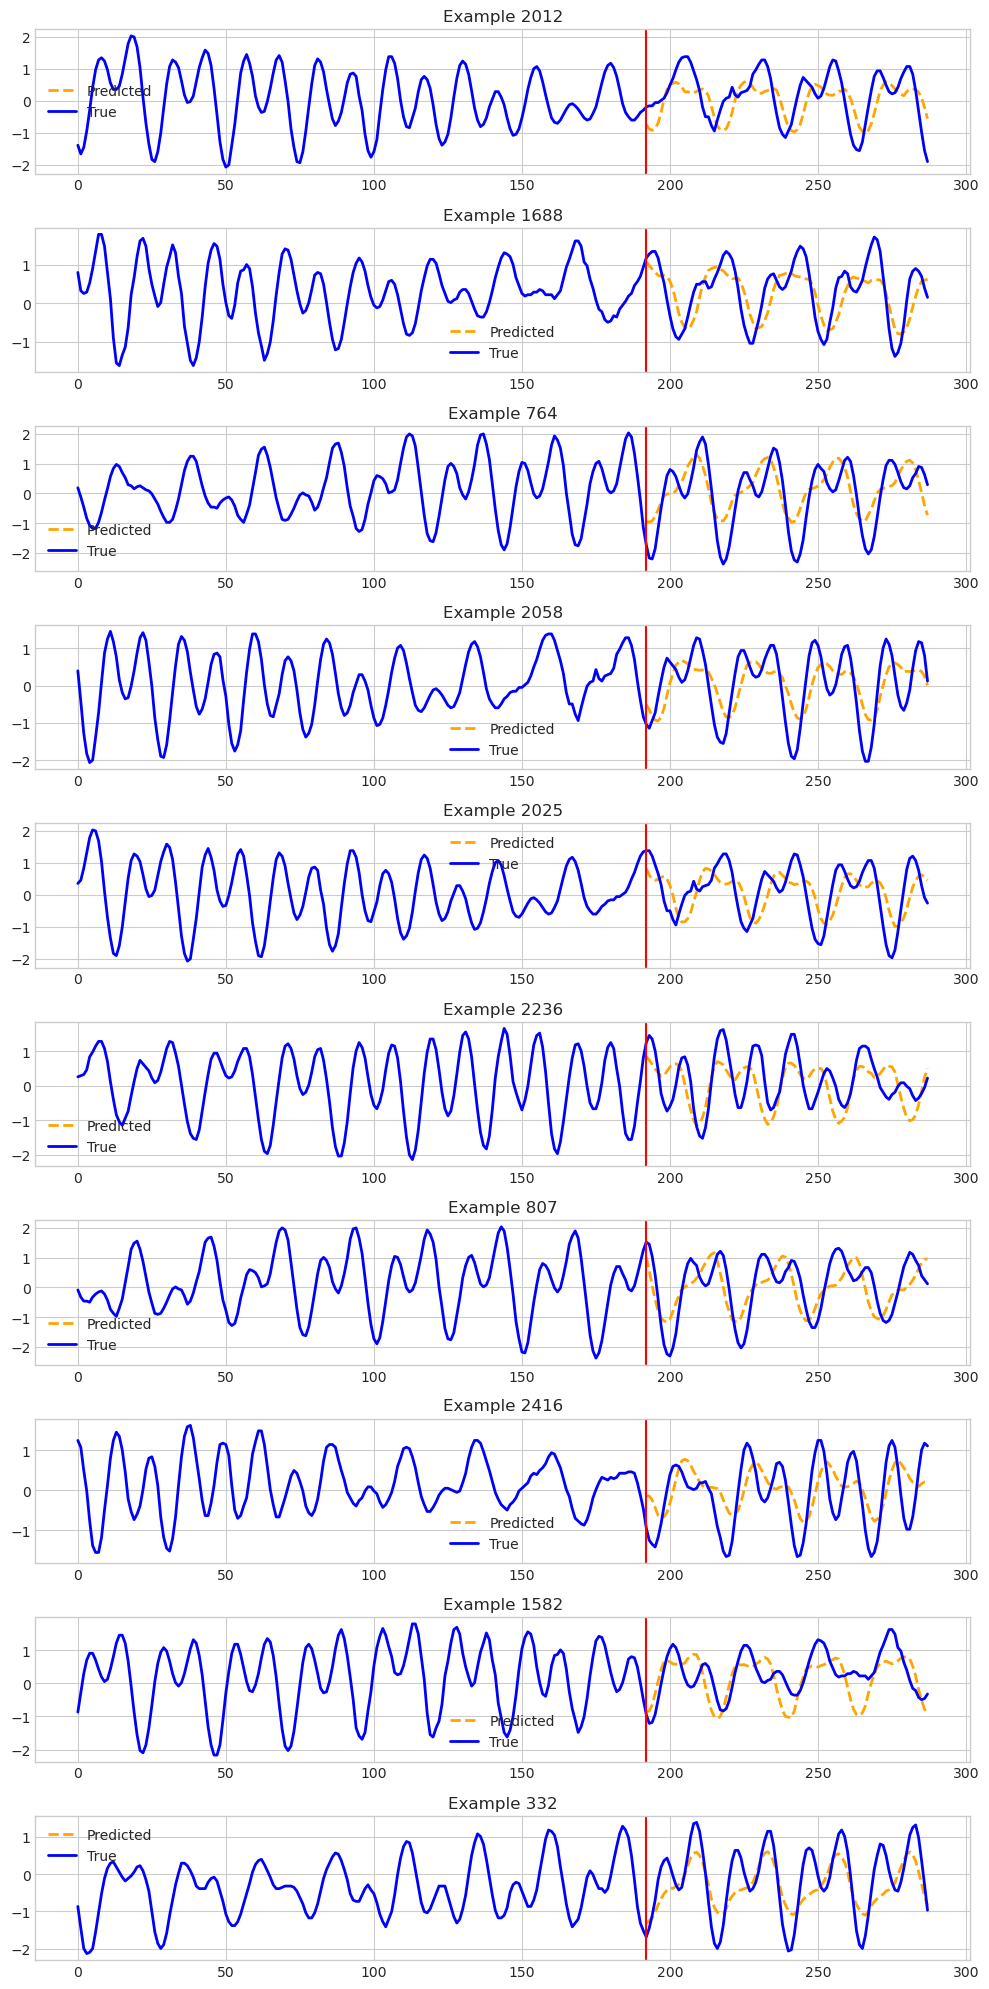

In [8]:
zeroshot_eval(dataset_name=target_dataset, batch_size=64)

### Few-shot 5%

-------------------- Running few-shot 5% --------------------
venice 1024 96


/tmp/wsuser/ipykernel_1454/3032330376.py:55: DeprecationWarning: Call to deprecated method get_datasets. (Please use the standalone function `get_datasets()`.) -- Deprecated since version 0.1.1.
  train_dataset, valid_dataset, test_dataset = tsp.get_datasets(


Data lengths: train = 388, val = 1434, test = 2960


/opt/conda/envs/Python-RT24.1-CUDA/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Number of params before freezing backbone 946336
Number of params after freezing the backbone 389984
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.895200,0.543264
2,0.815500,0.524271
3,0.821100,0.496727
4,0.747300,0.459381
5,0.666500,0.410270
6,0.509900,0.365745
7,0.432600,0.342903
8,0.300200,0.349234
9,0.207500,0.392222
10,0.167700,0.418251


[TrackingCallback] Mean Epoch Time = 0.45715003855088177 seconds, Total Train Time = 15.759763717651367
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.1786535680294037, 'eval_runtime': 0.5995, 'eval_samples_per_second': 4937.358, 'eval_steps_per_second': 78.397, 'epoch': 17.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


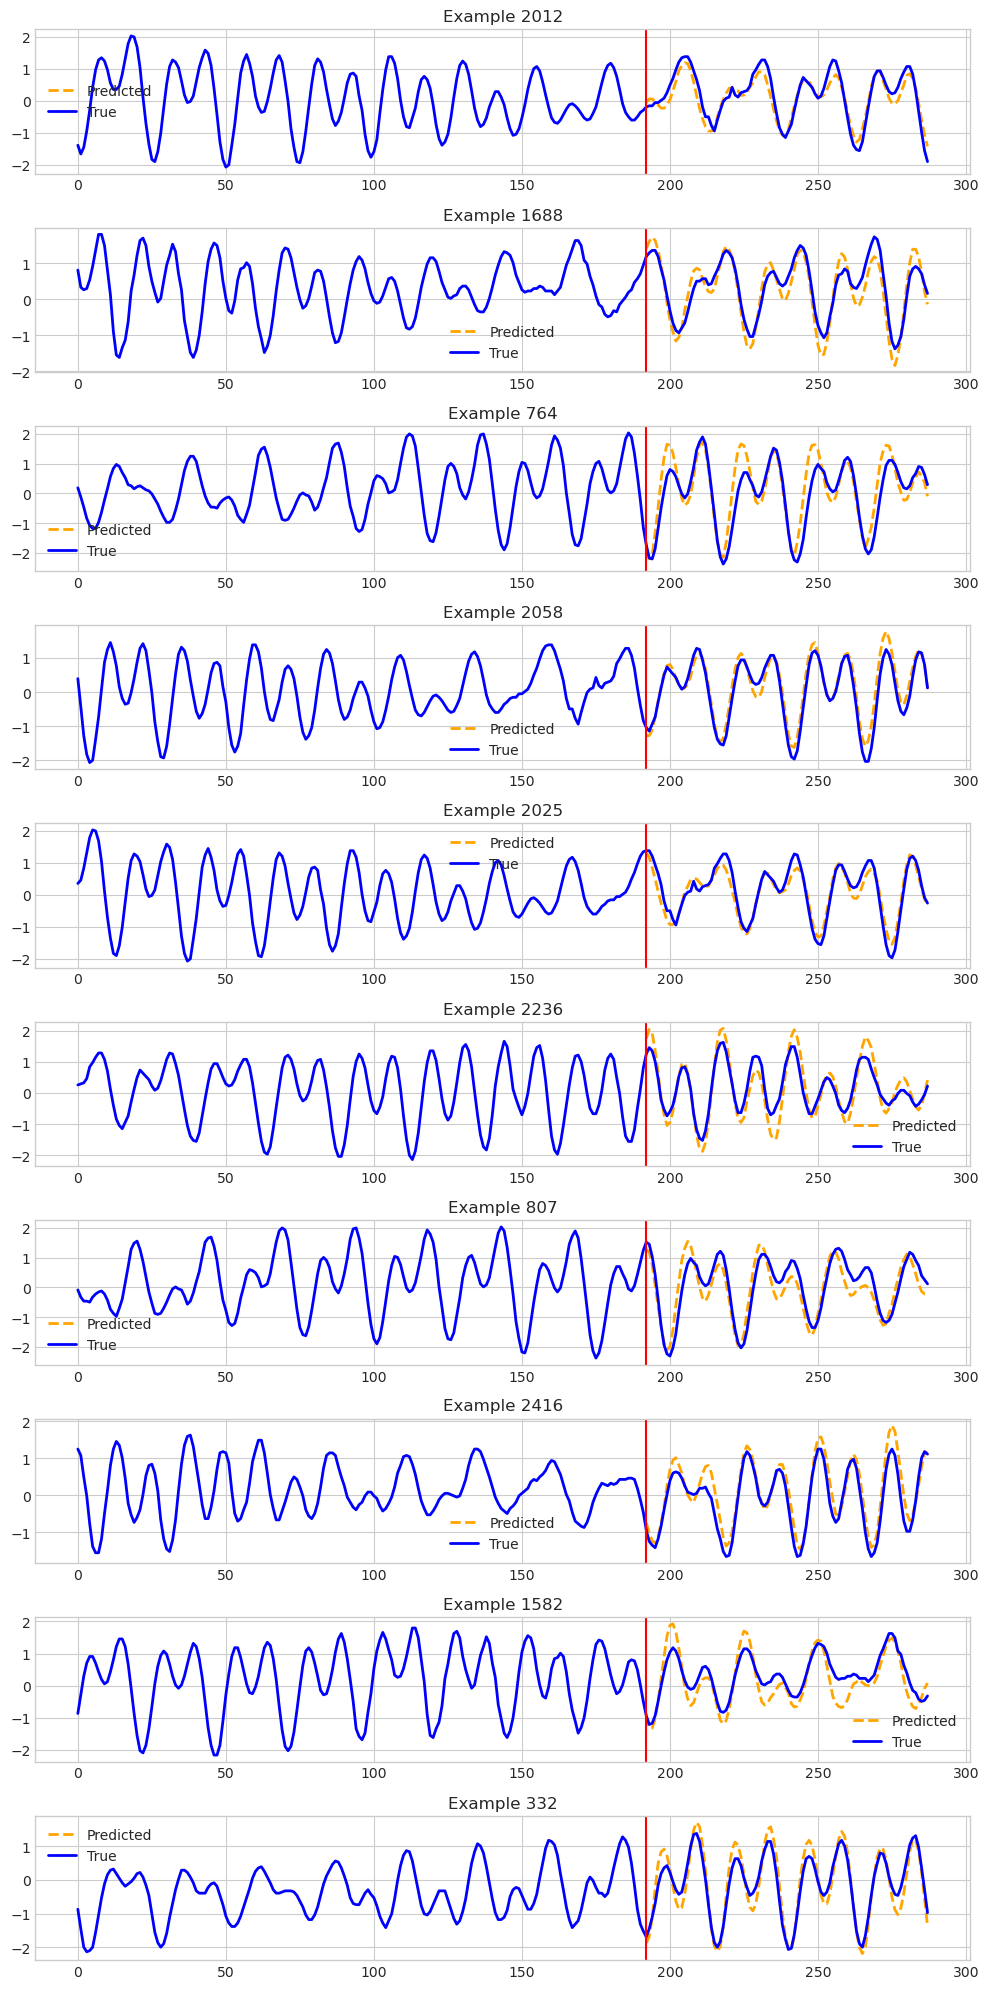

In [9]:
fewshot_finetune_eval(dataset_name=target_dataset, batch_size=64)